In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Overview

In the previous post, we covered the following topics:
    
- A Gaussian process (GP) defines a distribution over functions (i.e. function evaluations). √
- Marginalizing a Gaussian over a subset of its elements gives another Gaussian (just pluck out the pieces of interest). √
- Conditioning a subset of the elements of a Gaussian on another subset gives another Gaussian (a simple algebraic formula). √
- Posterior over functions (the linear map of the posterior over weights onto some matrix $A = \phi(X_{*})^T$) √
- Covariances (the second thing we need in order to specify a multivariate Gaussian) √

**If any of the above is still not clear, please look no further, and re-visit the [previous post]().**

Conversely, we did not directly cover:

- Kernels
- Squared-exponentials

Here, we'll explain these two.

# The more features we use, the more expressive our model

We concluded the previous post by plotting posteriors over function evaluations given various `phi_func`s, i.e. a function that creates "features" $\phi(X)$ given an input $X$. 

For example:

```python
X_train = np.array([-3, -5, 6, 2, 1])  # 5 inputs
y_train = np.array([1, 4, 2, 9, 4])  # 5 corresponding outputs, which we'll use below

def phi_func(x):
    return np.array([3 * np.cos(x), np.abs(x - np.abs(x - 3))])  # makes D=2 features for each input
    
    
>>> phi_func(X_train).shape
(2, 5)
```

One common such set of features are those given by "radial basis functions", a.k.a. the "squared exponential" function, defined as:

```python
def phi_func(x, D=D):
    return np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])  # phi_x.shape: (D, len(x))
```

Again, the choice of which features to use is ultimately arbitrary, i.e. a choice left to the modeler. 

Throughout the exercise, we saw that the larger the dimensionality $d$ of our feature function `phi_func`, the more expressive, i.e. less endemically prone to overfitting, our model became.

**So, how far can we take this?**

# Computing features is expensive

Ideally, we'd compute as many features as possible for each input element, i.e. employ `phi_func(x, D=some_huge_number)`. Tragically, the cost of doing so adds up, and ultimately becomes intractable past meaningfully large values of $d$. 

**Perhaps there's a better way?**

# How are these things used?

Let's bring back our GP equations, and prepare ourselves to *squint*! In the previous post, we noted:

### Marginalizing $P(w, y)$ over $y$ gives the posterior distribution over weights, $P(w\vert y)$.

- First, the mathematical equation:

$$
\begin{align*}
P(w\vert y)
    &= \mathcal{N}(\mu_w + \Sigma_{wy}\Sigma_y^{-1}(y - \mu_y), \Sigma_w - \Sigma_{wy}\Sigma_y^{-1}\Sigma_{wy}^T)\\
    \\
    &= \mathcal{N}(\mu_w + \Sigma_{wy}(\phi(X)^T\Sigma_w \phi(X))^{-1}(y - \mu_w^T \phi(X)), \Sigma_w - \Sigma_{wy}(\phi(X)^T\Sigma_w \phi(X))^{-1}\Sigma_{wy}^T)
\end{align*}
$$

- Next, this equation in code:

```python
# Define initial parameters
D = ...  # dimensionality of `phi_func`

mu_w = np.zeros(D)  # often a vector of zeros, though it doesn't have to be
cov_w = np.eye(D)  # often the identity matrix, though it doesn't have to be

# Featurize `X_train`
phi_x = phi_func(X_train, D=D)

# Params of prior distribution over function evals
mu_y = phi_x.T @ mu_w
     = np.zeros(D)
cov_y = phi_x.T @ cov_w @ phi_x

# Params of posterior distribution over weights
mu_w_post = mu_w + cov_w @ phi_x @ np.linalg.inv(cov_y) @ (y_train - mu_y)
          = mu_w + cov_w @ phi_x @ np.linalg.inv(cov_y) @ y_train
cov_w_post = cov_w - cov_w @ phi_x @ np.linalg.inv(cov_y) @ phi_x.T @ cov_w
           = cov_w - cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ phi_x.T @ cov_w
```

### The linear map of $P(w\vert y)$ onto some matrix $\phi(X_*)^T$ gives the posterior distribution over function evaluations, $P(y_*\ \vert\ y)$.

Here, $X_*$ is a set of test points, e.g. `np.linspace(-10, 10, 200)`, and $P(y_*\ \vert\ y) = P(\phi(X_{*})^Tw\ \vert\ y)$.

For readability, let's call $X_* \rightarrow$ `X_test` and $y_* \rightarrow$ `y_test`.

- The mathematical equations in code:

```python
# Featurize `X_test`
phi_x_test = phi_func(X_test, D=D)

# The following two equations were defined above
mu_w_post = cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ y_train 
cov_w_post = cov_w - cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ phi_x.T @ cov_w

# The mean of the posterior distribution over function evaluations
mu_y_test_post = phi_x_test.T @ mu_w_post
               = phi_x_test.T @ cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ y_train

# The covariance of the posterior distribution over function evaluations
cov_y_test_post = phi_x_test.T @ cov_w_post @ phi_x_test
                = phi_x_test.T @ cov_w @ phi_x_test - \
                  phi_x_test.T @ cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ \
                  phi_x.T @ cov_w @ phi_x_test
```

# Never alone

Squinting at the equations for `mu_y_test_post` and `cov_y_test_post`, we see that `phi_x` and `phi_x_test` appear **only in the presence of another `phi_x`, or `phi_x_test`.** 

These four distinct such terms are:

```python
phi_x_test.T @ cov_w @ phi_x_test
phi_x_test.T @ cov_w @ phi_x
phi_x.T @ cov_w @ phi_x
phi_x.T @ cov_w @ phi_x_test
```

In mathematical notation, they are (respectively):

- $\phi(X_*)^T\Sigma_w \phi(X_*)$
- $\phi(X_*)^T\Sigma_w \phi(X)$
- $\phi(X)^T\Sigma_w \phi(X)$
- $\phi(X)^T\Sigma_w \phi(X_*)$

# Simplifying further

These are nothing more than *scaled* (via the $\Sigma_w$ term) dot products in some expanded feature space $\phi$. 

*Until now, we've explicitly chosen what this $\phi$ function is.*

If the scaling matrix $\Sigma_w$ is [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix), we can state the following, using $\phi(X)^T\Sigma_w \phi(X)$, i.e. `phi_x.T @ cov_w @ phi_x`, as an example:

$$
\begin{align*}
\Sigma_w = (\sqrt{\Sigma_w})^2
\end{align*}
$$

$$
\begin{align*}
\phi(X)^T \Sigma_w \phi(X) 
    &= \big(\sqrt{\Sigma_w}\phi(X)\big)^T\big(\sqrt{\Sigma_w}\phi(X)\big)\\
    &= \varphi(X)^T\varphi(X)\\
    &= \varphi(X) \cdot \varphi(X)\\
\end{align*}
$$

As such, our four distinct scaled-dot-product terms can be rewritten as:

- $\phi(X_*)^T\Sigma_w \phi(X_*) = \varphi(X_*) \cdot \varphi(X_*)$
- $\phi(X_*)^T\Sigma_w \phi(X) = \varphi(X_*) \cdot \varphi(X)$
- $\phi(X)^T\Sigma_w \phi(X) = \varphi(X) \cdot \varphi(X)$
- $\phi(X)^T\Sigma_w \phi(X_*) = \varphi(X) \cdot \varphi(X_*)$

**In other words, these terms can be equivalently written as dot-products in some space $\varphi$.** 

*We have **not** explicitly chosen what this $\varphi$ function is.*

# Kernels

A "kernel" is a function which gives the similarity between individual elements in two sets, i.e. a Gram matrix.

For instance, imagine we have two sets of countries, $\{\text{France}, \text{Germany}, \text{Iceland}\}$ and $\{\text{Morocco}, \text{Denmark}\}$, and that similarity is given by an integer value in $[1, 5]$, where 1 is the least similar, and 5 is the most. Applying a kernel to these sets might give a Gram matrix such as:

In [2]:
import pandas as pd

pd.DataFrame([[4, 2, 1], [3, 3, 4]], columns=['France', 'Germany', 'Iceland'], index=['Morocco', 'Denmark'])

,France,Germany,Iceland
Morocco,4,2,1
Denmark,3,3,4


**When you hear the term "kernel" in the context of machine learning, think "similarity between things in lists." That's it.**

NB: A "list" could be a list of vectors, i.e. a matrix. A vector, or a matrix, are the canonical inputs to a kernel.

# Mercer's Theorem

Mercer's Theorem has as a key result that any kernel function can be expressed as a dot product, i.e.

$$
K(X, X') = \varphi(X) \cdot \varphi (X')
$$

where $\varphi$ is some function that creates $d$ features out of $X$ (in the same vein as `phi_func` from above).

## Example

To illustrate, I'll borrow an example from [CrossValidated](https://stats.stackexchange.com/questions/152897/how-to-intuitively-explain-what-a-kernel-is):


"For example, consider a simple polynomial kernel $K(\mathbf x, \mathbf y) = (1 + \mathbf x^T \mathbf y)^2$ with $\mathbf x, \mathbf y \in \mathbb R^2$. This doesn't seem to correspond to any mapping function $\varphi$, it's just a function that returns a real number. Assuming that $\mathbf x = (x_1, x_2)$ and $\mathbf y = (y_1, y_2)$, let's expand this expression:

$$
\begin{align}
K(\mathbf x, \mathbf y) 
    &= (1 + \mathbf x^T \mathbf y)^2\\
    &= (1 + x_1 \, y_1  + x_2 \, y_2)^2\\
    &= 1 + x_1^2 y_1^2 + x_2^2 y_2^2 + 2 x_1 y_1 + 2 x_2 y_2 + 2 x_1 x_2 y_1 y_2
\end{align}
$$

Note that this is nothing else but a dot product between two vectors $(1, x_1^2, x_2^2, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_1 x_2)$ and $(1, y_1^2, y_2^2, \sqrt{2} y_1, \sqrt{2} y_2, \sqrt{2} y_1 y_2)$, and $\varphi(\mathbf x) = \varphi(x_1, x_2) = (1, x_1^2, x_2^2, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_1 x_2)$. So the kernel $K(\mathbf x, \mathbf y) = (1 + \mathbf x^T \mathbf y)^2 = \varphi(\mathbf x) \cdot \varphi(\mathbf y)$ computes a dot product in 6-dimensional space without explicitly visiting this space."

## What this means

![](./kernels-for-gaussian-processes.svg)

- We start with inputs $X$ and $Y$.
- Our goal is to compute the similarity between then, $\text{Sim}(X, Y)$.

### Bottom path
- Lifting these inputs into some feature space, then computing their dot-product in that space, i.e. $\varphi(X) \cdot \varphi (Y)$ (where $F = \varphi$, since I couldn't figure out how to draw a $\varphi$ in [draw.io](http://draw.io)), is one strategy for computing this similarity.
- Unfortunately, this robustness comes at a cost: **the computation is extremely expensive.**

### Top Path
- A valid kernel computes similarity between inputs. The function it employs might be extremely simple, e.g. $(X - Y)^{123}$; **the computation is extremely cheap.**

### Mercer!
- Mercer's Theorem tells us that every valid kernel, i.e. the top path, is *implicitly traversing the bottom path.* **In other words, kernels allow us to directly compute the result of an extremely expensive computation, extremely cheaply.**

# How does this help?

Once more, the Gaussian process equations are littered with the following terms:

- $\phi(X_*)^T\Sigma_w \phi(X_*) = \varphi(X_*) \cdot \varphi(X_*)$
- $\phi(X_*)^T\Sigma_w \phi(X) = \varphi(X_*) \cdot \varphi(X)$
- $\phi(X)^T\Sigma_w \phi(X) = \varphi(X) \cdot \varphi(X)$
- $\phi(X)^T\Sigma_w \phi(X_*) = \varphi(X) \cdot \varphi(X_*)$

In addition, we previously established that the more we increase the dimensionality $d$ of our given feature function, the more flexible our model becomes.

Finally, past any meaningfully large value of $d$, and irrespective of what $\varphi$ actually is, **this computation becomes intractably expensive.**

## Kernels!

You know where this is going.

Given Mercer's theorem, we can state the following equalities:

- $\varphi(X_*) \cdot \varphi(X_*) = K(X_*, X_*)$
- $\varphi(X_*) \cdot \varphi(X) = K(X_*, X)$
- $\varphi(X) \cdot \varphi(X) = K(X, X)$
- $\varphi(X) \cdot \varphi(X_*) = K(X, X_*)$

# Which kernels to choose?

At the outset, we stated that our primary goal was to increase $d$. As such, **let's pick the kernel whose implicit $\varphi$ has the largest dimensionality possible.**

In the example above, we saw that the kernel $k(\mathbf x, \mathbf y)$ was implicitly computing a $d=6$-dimensional dot-product. Which kernels compute a $d=100$-dimensional dot-product? $d=1000$?

**How about $d=\infty$?**

# Radial basis function, a.k.a. the "squared-exponential"

This kernel is implicitly computing a $d=\infty$-dimensional dot-product. That's it. **That's why it's so ubiquitous in Gaussian processes.**

# Rewriting our equations

With all of the above in mind, let's rewrite the equations for the parameters of our posterior distribution over function evaluations.

```python
# The mean of the posterior distribution over function evaluations
mu_y_test_post = phi_x_test.T @ mu_w_post
               = phi_x_test.T @ cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ y_train
               
               # Now, substituting in our kernels
               = k(X_test, X_train) @ np.linalg.inv(k(X_train, X_train)) @ y_train

# The covariance of the posterior distribution over function evaluations
cov_y_test_post = phi_x_test.T @ cov_w_post @ phi_x_test
                = phi_x_test.T @ cov_w @ phi_x_test - \
                  phi_x_test.T @ cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ \
                  phi_x.T @ cov_w @ phi_x_test
                  
                # Now, substituting in our kernels
                = k(X_test, X_test) - \
                  k(X_test, X_train) @ np.linalg.inv(k(X_train, X_train)) @ k(X_train, X_test)
```

# Defining the kernel in code

Mathematically, the RBF kernel is defined as follows:

$$
K(X, Y) = \exp(-\frac{1}{2}\vert X - Y \vert ^2)
$$

To conclude, let's define a Python function for the parameters of our posterior over function evaluations, using this RBF kernel as `k`, then plot the resulting distribution.

In [39]:
X_train = np.array([-3, -5, 6, 2, 1])  # 5 inputs
y_train = np.array([1, 4, 2, 9, 4])  # 5 corresponding outputs, which we'll use below
X_test = np.linspace(-10, 10, 200)  # vector of test inputs


def rbf_kernel(x, y):
    x = np.expand_dims(x, 1)  # shape: (len(x), 1)
    y = np.expand_dims(y, 0)  # shape: (1, len(y))
    return np.exp(-.5 * (x - y)**2)  # shape: (len(x), len(y))


def k(x, y):
    return rbf_kernel(x, y)
    

# The following quantity is used in both `mu_y_test_post` and `cov_y_test_post`; 
# we extract it into a separate variable for readability
A = k(X_test, X_train) @ np.linalg.inv(k(X_train, X_train))

mu_y_test_post = A @ y_train            
cov_y_test_post = k(X_test, X_test) - A @ k(X_train, X_test)

# Plot results

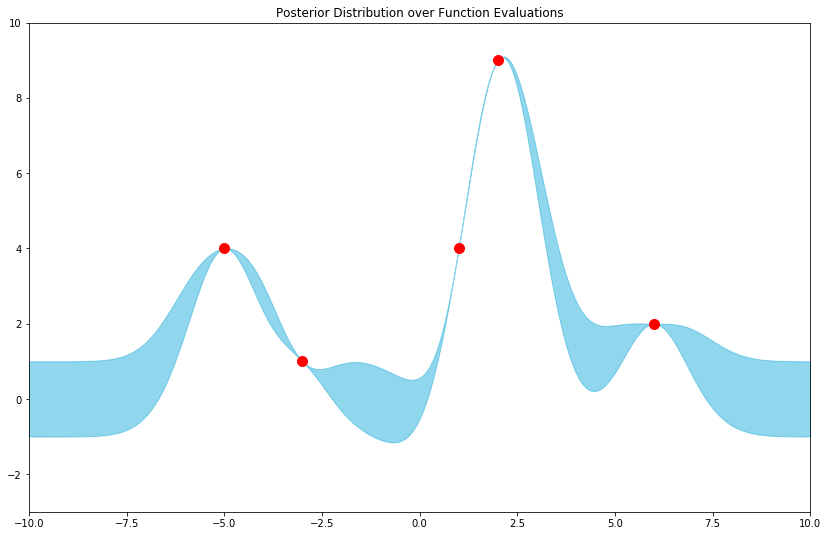

In [41]:
def plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=0, ylim=(-3, 10)):
    plt.figure(figsize=(14, 9))
    plt.ylim(*ylim)
    plt.xlim(-10, 10)
    plt.title('Posterior Distribution over Function Evaluations')

    # Extract the variances, i.e. the diagonal, of our covariance matrix
    var_y_post = np.diag(cov_y_post)

    # Plot the error bars.
    # To do this, we fill the space between `(mu_y_post - var_y_post, mu_y_post + var_y_post)` for each `x`
    plt.fill_between(x_test, mu_y_post - var_y_post, mu_y_post + var_y_post, color='#23AEDB', alpha=.5)

    # Scatter-plot our original `(x, y)` tuples
    plt.plot(x_train, y_train, 'ro', markersize=10)

    # Optionally plot actual samples (function evaluations) from this posterior
    if n_samples > 0:
        for _ in range(n_samples):
            y_pred = np.random.multivariate_normal(mu_y_post, cov_y_post)
            plt.plot(x_test, y_pred, alpha=.2)


plot_gp_posterior(mu_y_test_post, cov_y_test_post, X_train, y_train, X_test, n_samples=0)

And for good measure, with some samples from the posterior:

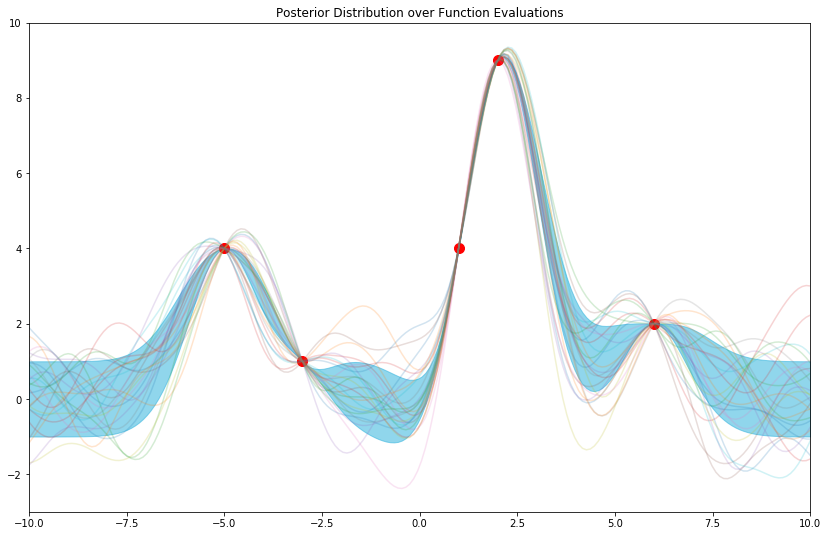

In [38]:
plot_gp_posterior(mu_y_test_post, cov_y_test_post, X_train, y_train, X_test, n_samples=25)

# In summary

In this post, we've unpacked the notion of a kernel, and its ubiquitous use in Gaussian Processes. 

In addition, we've introduced the RBF kernel, i.e. "squared exponential" kernel, and motivated its widespread application in these models.